<a href="https://colab.research.google.com/github/MpRonald/Machine-Learning/blob/main/Temporal_Analysis_EuroxReal_by_FbProphet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pystan~=2.14
!pip install fbprophet

In [ ]:
import pandas as pd
import seaborn as sns
from fbprophet import Prophet

In [112]:
data = pd.read_csv('https://github.com/MpRonald/datasets/raw/main/EUR_BRL%20Dados%20Hist%C3%B3ricos%20(1).csv')
data.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,25 de ago. de 2022,"5,1105","5,0950","5,1283","5,0745","95,90K","0,36%"
1,24 de ago. de 2022,"5,0922","5,0902","5,1036","5,0480","196,00K","0,10%"
2,23 de ago. de 2022,"5,0869","5,1287","5,1323","5,0624","214,26K","-0,78%"
3,22 de ago. de 2022,"5,1270","5,1918","5,1957","5,1157","211,03K","-1,16%"
4,19 de ago. de 2022,"5,1873","5,2160","5,2445","5,1844","209,42K","-0,49%"


In [113]:
dataset = pd.DataFrame()
dataset[['date', 'value']] = data[['Data','Último']]

In [114]:
dataset.head()

,date,value
0,25 de ago. de 2022,"5,1105"
1,24 de ago. de 2022,"5,0922"
2,23 de ago. de 2022,"5,0869"
3,22 de ago. de 2022,"5,1270"
4,19 de ago. de 2022,"5,1873"


In [115]:
dataset.shape

(3299, 2)

In [116]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3299 entries, 0 to 3298
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    3299 non-null   object
 1   value   3299 non-null   object
dtypes: object(2)
memory usage: 51.7+ KB


In [117]:
dataset.date[2292].split()

['12', 'de', 'nov.', 'de', '2013']

In [118]:
year = dataset.date[2292].split()[4]
year

'2013'

In [119]:
dataset.date.str.split()

0       [25, de, ago., de, 2022]
1       [24, de, ago., de, 2022]
2       [23, de, ago., de, 2022]
3       [22, de, ago., de, 2022]
4       [19, de, ago., de, 2022]
                  ...           
3294    [08, de, jan., de, 2010]
3295    [07, de, jan., de, 2010]
3296    [06, de, jan., de, 2010]
3297    [05, de, jan., de, 2010]
3298    [04, de, jan., de, 2010]
Name: date, Length: 3299, dtype: object

In [120]:
len(dataset.date.str.split())

3299

In [121]:
col = []
for i in range(0,5):
    print(f'Col {[i]} = {dataset.date.str.split(expand=True)[i].unique()}\
    len: {len(dataset.date.str.split(expand=True)[i].unique())}')

Col [0] = ['25' '24' '23' '22' '19' '18' '17' '16' '15' '12' '11' '10' '09' '08'
 '05' '04' '03' '02' '01' '29' '28' '27' '26' '21' '20' '14' '13' '07'
 '06' '30' '31']    len: 31
Col [1] = ['de']    len: 1
Col [2] = ['ago.' 'jul.' 'jun.' 'mai.' 'abr.' 'mar.' 'fev.' 'jan.' 'dez.' 'nov.'
 'out.' 'set.']    len: 12
Col [3] = ['de']    len: 1
Col [4] = ['2022' '2021' '2020' '2019' '2018' '2017' '2016' '2015' '2014' '2013'
 '2012' '2011' '2010']    len: 13


In [122]:
dataset['year'] = dataset.date.str.split(expand=True)[4]
dataset['month'] = dataset.date.str.split(expand=True)[2]
dataset['day'] = dataset.date.str.split(expand=True)[0]

In [124]:
dataset.month.unique()

array(['ago.', 'jul.', 'jun.', 'mai.', 'abr.', 'mar.', 'fev.', 'jan.',
       'dez.', 'nov.', 'out.', 'set.'], dtype=object)

In [126]:
dataset.month = dataset['month'].map({'ago.':8, 'jul.':7, 'jun.':6, 'mai.':5,
                                     'abr.':4, 'mar.':3, 'fev.':2, 'jan.':1,
                                     'dez.':12, 'nov.':11, 'out.':10, 'set.':9})

In [128]:
dataset

,date,value,year,month,day
0,25 de ago. de 2022,"5,1105",2022,8,25
1,24 de ago. de 2022,"5,0922",2022,8,24
2,23 de ago. de 2022,"5,0869",2022,8,23
3,22 de ago. de 2022,"5,1270",2022,8,22
4,19 de ago. de 2022,"5,1873",2022,8,19
...,...,...,...,...,...
3294,08 de jan. de 2010,"2,4884",2010,1,08
3295,07 de jan. de 2010,"2,5004",2010,1,07
3296,06 de jan. de 2010,"2,4974",2010,1,06
3297,05 de jan. de 2010,"2,4873",2010,1,05


In [129]:
date_transform = dataset.iloc[:,2:]
date_transform

,year,month,day
0,2022,8,25
1,2022,8,24
2,2022,8,23
3,2022,8,22
4,2022,8,19
...,...,...,...
3294,2010,1,08
3295,2010,1,07
3296,2010,1,06
3297,2010,1,05


In [131]:
from datetime import datetime
def process(line):
   valores = [int(val) for val in (line["year"], line["month"], line["day"])]
   return datetime(*valores)

timestamps = date_transform.apply(process, axis=1)
timestamps.name = "timestamps" 
timestamps

0      2022-08-25
1      2022-08-24
2      2022-08-23
3      2022-08-22
4      2022-08-19
          ...    
3294   2010-01-08
3295   2010-01-07
3296   2010-01-06
3297   2010-01-05
3298   2010-01-04
Name: timestamps, Length: 3299, dtype: datetime64[ns]

In [132]:
dataset['ds'] = timestamps
dataset

,date,value,year,month,day,ds
0,25 de ago. de 2022,"5,1105",2022,8,25,2022-08-25
1,24 de ago. de 2022,"5,0922",2022,8,24,2022-08-24
2,23 de ago. de 2022,"5,0869",2022,8,23,2022-08-23
3,22 de ago. de 2022,"5,1270",2022,8,22,2022-08-22
4,19 de ago. de 2022,"5,1873",2022,8,19,2022-08-19
...,...,...,...,...,...,...
3294,08 de jan. de 2010,"2,4884",2010,1,08,2010-01-08
3295,07 de jan. de 2010,"2,5004",2010,1,07,2010-01-07
3296,06 de jan. de 2010,"2,4974",2010,1,06,2010-01-06
3297,05 de jan. de 2010,"2,4873",2010,1,05,2010-01-05


In [133]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3299 entries, 0 to 3298
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3299 non-null   object        
 1   value   3299 non-null   object        
 2   year    3299 non-null   object        
 3   month   3299 non-null   int64         
 4   day     3299 non-null   object        
 5   ds      3299 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 154.8+ KB


In [134]:
# dataset_mod_type = {'year': int}
# dataset = dataset.astype(dataset_mod_type)

In [135]:
dataset['value'] = dataset.value.replace({',': '.'}, regex=True)

In [136]:
dataset_mod_type = {'value': float}
dataset = dataset.astype(dataset_mod_type)

In [140]:
df = dataset[['ds','value']]
df = df.rename(columns={'value': 'y'})
df

,ds,y
0,2022-08-25,5.1105
1,2022-08-24,5.0922
2,2022-08-23,5.0869
3,2022-08-22,5.1270
4,2022-08-19,5.1873
...,...,...
3294,2010-01-08,2.4884
3295,2010-01-07,2.5004
3296,2010-01-06,2.4974
3297,2010-01-05,2.4873


In [141]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3299 entries, 0 to 3298
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3299 non-null   object        
 1   value   3299 non-null   float64       
 2   year    3299 non-null   object        
 3   month   3299 non-null   int64         
 4   day     3299 non-null   object        
 5   ds      3299 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 154.8+ KB


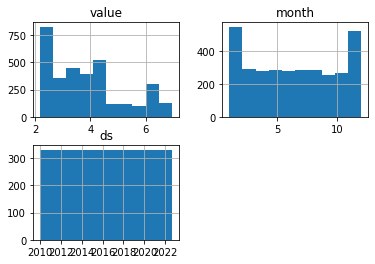

In [142]:
dataset.hist();

In [143]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
value,3299.0,3.866632,1.317225,2.1733,2.6575,3.6429,4.50525,6.9584
month,3299.0,6.421037,3.427415,1.0000,3.0000,6.0000,9.00000,12.0000


In [144]:
dataset.isnull().sum()

date     0
value    0
year     0
month    0
day      0
ds       0
dtype: int64

In [146]:
df = df.sort_values(by='ds')
df

,ds,y
3298,2010-01-04,2.4809
3297,2010-01-05,2.4873
3296,2010-01-06,2.4974
3295,2010-01-07,2.5004
3294,2010-01-08,2.4884
...,...,...
4,2022-08-19,5.1873
3,2022-08-22,5.1270
2,2022-08-23,5.0869
1,2022-08-24,5.0922


###Predictions

In [148]:
model = Prophet().fit(df)
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)
forecast.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-01-04,2.466286,2.123853,2.839699,2.466286,2.466286,0.006292,0.006292,0.006292,0.008503,0.008503,0.008503,-0.002212,-0.002212,-0.002212,0.0,0.0,0.0,2.472578
1,2010-01-05,2.465546,2.097237,2.837308,2.465546,2.465546,-0.001603,-0.001603,-0.001603,0.003377,0.003377,0.003377,-0.004980,-0.004980,-0.004980,0.0,0.0,0.0,2.463943
2,2010-01-06,2.464806,2.092111,2.830896,2.464806,2.464806,-0.005800,-0.005800,-0.005800,0.001923,0.001923,0.001923,-0.007724,-0.007724,-0.007724,0.0,0.0,0.0,2.459005
3,2010-01-07,2.464066,2.106602,2.816106,2.464066,2.464066,-0.007262,-0.007262,-0.007262,0.003174,0.003174,0.003174,-0.010436,-0.010436,-0.010436,0.0,0.0,0.0,2.456803
4,2010-01-08,2.463325,2.124536,2.799210,2.463325,2.463325,-0.008020,-0.008020,-0.008020,0.005090,0.005090,0.005090,-0.013110,-0.013110,-0.013110,0.0,0.0,0.0,2.455305


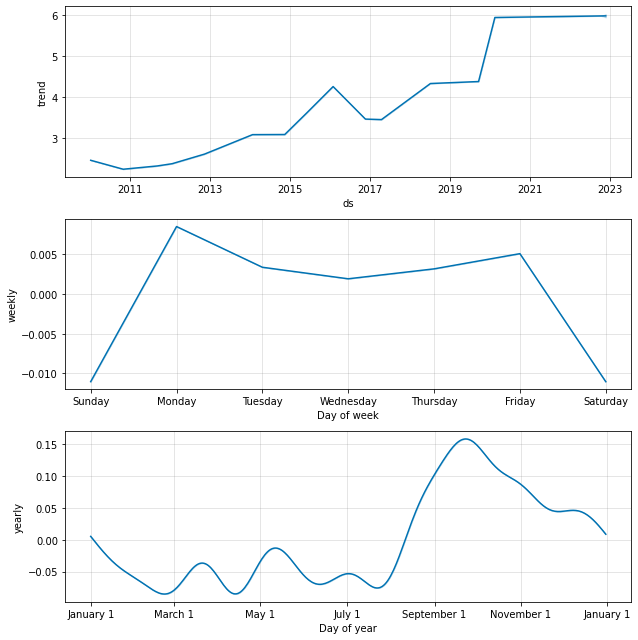

In [149]:
model.plot_components(forecast);

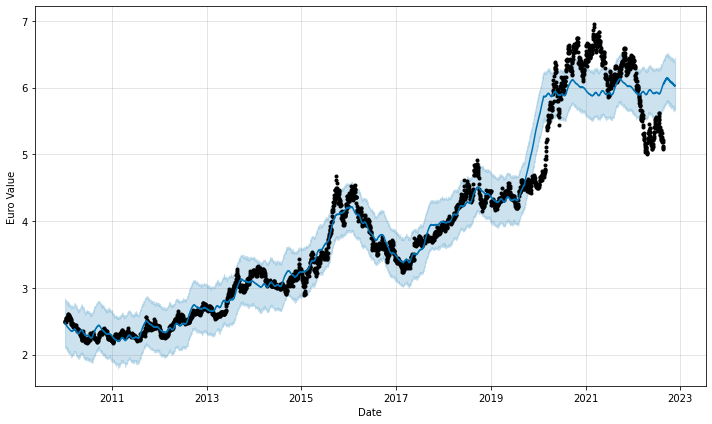

In [151]:
model.plot(forecast, xlabel = 'Date', ylabel = 'Euro Value');